In [55]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, StackingRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

In [37]:
# Your selected columns
selected_num_columns = ['LotFrontage', 'LotArea', 'TotalBsmtSF', 'GrLivArea', 'SalePrice']
categorical_columns_filtered = ['Street', 'LandContour', 'LandSlope', 'Utilities', 'Neighborhood',
                                  'Condition1', 'Condition2', 'HouseStyle', 'BldgType', 'OverallQual',
                                  'OverallCond', 'RoofStyle', 'Exterior1st', 'ExterCond', 'BsmtCond',
                                  'BsmtFinType1', 'CentralAir', 'Heating', 'KitchenQual',
                                  'TotRmsAbvGrd', 'GarageType', 'GarageCond', 'PavedDrive',
                                  'SaleType', 'SaleCondition', 'Fireplaces', 'GarageCars']

categorical_columns_filtered = [ 'LandSlope',  'Neighborhood',
                                  'Condition1',  'HouseStyle', 'BldgType', 'OverallQual',
                                  'OverallCond', 'RoofStyle', 'Exterior1st', 'ExterCond', 'BsmtCond',
                                  'BsmtFinType1', 'KitchenQual',
                                  'TotRmsAbvGrd', 'GarageType',  'PavedDrive',
                                  'SaleType', 'SaleCondition', 'Fireplaces', 'GarageCars']

In [38]:
train_set = pd.read_csv('../data/train.csv')
test_set = pd.read_csv('../data/test.csv')

In [39]:
for column in categorical_columns_filtered[3:]:
    print(train_set[column].value_counts())
    

HouseStyle
1Story    726
2Story    445
1.5Fin    154
SLvl       65
SFoyer     37
1.5Unf     14
2.5Unf     11
2.5Fin      8
Name: count, dtype: int64
BldgType
1Fam      1220
TwnhsE     114
Duplex      52
Twnhs       43
2fmCon      31
Name: count, dtype: int64
OverallQual
5     397
6     374
7     319
8     168
4     116
9      43
3      20
10     18
2       3
1       2
Name: count, dtype: int64
OverallCond
5    821
6    252
7    205
8     72
4     57
3     25
9     22
2      5
1      1
Name: count, dtype: int64
RoofStyle
Gable      1141
Hip         286
Flat         13
Gambrel      11
Mansard       7
Shed          2
Name: count, dtype: int64
Exterior1st
VinylSd    515
HdBoard    222
MetalSd    220
Wd Sdng    206
Plywood    108
CemntBd     61
BrkFace     50
WdShing     26
Stucco      25
AsbShng     20
BrkComm      2
Stone        2
AsphShn      1
ImStucc      1
CBlock       1
Name: count, dtype: int64
ExterCond
TA    1282
Gd     146
Fa      28
Ex       3
Po       1
Name: count, dtype: int6

In [40]:
# Define the target and features
# SalePrice is the target, so exclude it from features.
X = train_set[[col for col in selected_num_columns if col != 'SalePrice'] + categorical_columns_filtered]
y = train_set['SalePrice']

In [60]:
import xgboost as xgb

In [70]:





# Preprocessing for numerical features: imputation and scaling
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Preprocessing for categorical features: imputation and one-hot encoding
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine the numeric and categorical transformations
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, [col for col in selected_num_columns if col != 'SalePrice']),
        ('cat', categorical_transformer, categorical_columns_filtered)
    ])

# Define base models for stacking
base_models = [
    ('ridge', Ridge(alpha=1.0)),
    ('xgb', xgb.XGBRegressor(n_estimators=100, random_state=42)),
    ('lasso', Lasso(alpha=0.1))
    #('gbr', GradientBoostingRegressor(n_estimators=100, random_state=42))
]

# Define the final estimator (meta-model)
final_estimator = LinearRegression()

# Create the stacking regressor
stacking_reg = StackingRegressor(
    estimators=base_models,
    final_estimator=final_estimator,
    cv=5  # using 5-fold cross validation for stacking
)

# Build a pipeline that first preprocesses the data then fits the stacking regressor
stacking_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('stacking', stacking_reg)
])



In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [71]:
param_grid = {
    # Tuning hyperparameters for base estimators:
    'stacking__ridge__alpha': [0.01, 0.1, 1.0, 10.0],
    'stacking__lasso__alpha': [0.001, 0.01, 0.1, 1.0],  # Uncomment if you want to tune Lasso
    #'stacking__gbr__n_estimators': [100, 200, 300],
    'stacking__xgb__n_estimators': [100, 200, 300],
    'stacking__xgb__learning_rate': [0.01, 0.05, 0.1],
    
    # Tuning a parameter for the final estimator:
    'stacking__final_estimator__fit_intercept': [True, False]
}

In [72]:
grid_search = GridSearchCV(
    stacking_pipeline,  # our pipeline that includes preprocessing and the stacking regressor
    param_grid, 
    cv=5,                # number of cross-validation folds
    scoring=['neg_mean_squared_error', 'r2'], 
    refit='neg_mean_squared_error',       # scoring metric (adjust as needed)
    n_jobs=-1            # use all available cores
)



In [73]:
# Fit grid search on the training data
grid_search.fit(X_train, y_train)

# Output the best hyperparameters and score
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation R^2 score:", grid_search.best_score_)

c:\Users\maryi\anaconda3\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
c:\Users\maryi\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:658: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 167655732503.8954, tolerance: 696659484.3571945
  model = cd_fast.sparse_enet_coordinate_descent(
c:\Users\maryi\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:658: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 127577379034.81677, tolerance: 537415025.1745833
  model = cd_fast.sparse_enet_coordinate_descent(
c:\Users\maryi\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:658: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 119061729668.25824, 

Best parameters: {'stacking__final_estimator__fit_intercept': True, 'stacking__lasso__alpha': 0.1, 'stacking__ridge__alpha': 1.0, 'stacking__xgb__learning_rate': 0.05, 'stacking__xgb__n_estimators': 300}
Best cross-validation R^2 score: -1031818034.3584417


c:\Users\maryi\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:658: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 140939895627.68185, tolerance: 579592113.9945961
  model = cd_fast.sparse_enet_coordinate_descent(


In [74]:
from sklearn.metrics import mean_squared_error, r2_score,root_mean_squared_error

In [75]:

y_pred = grid_search.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)


In [76]:
rmse

28034.669817964044

In [77]:
r2

0.8975346431725638

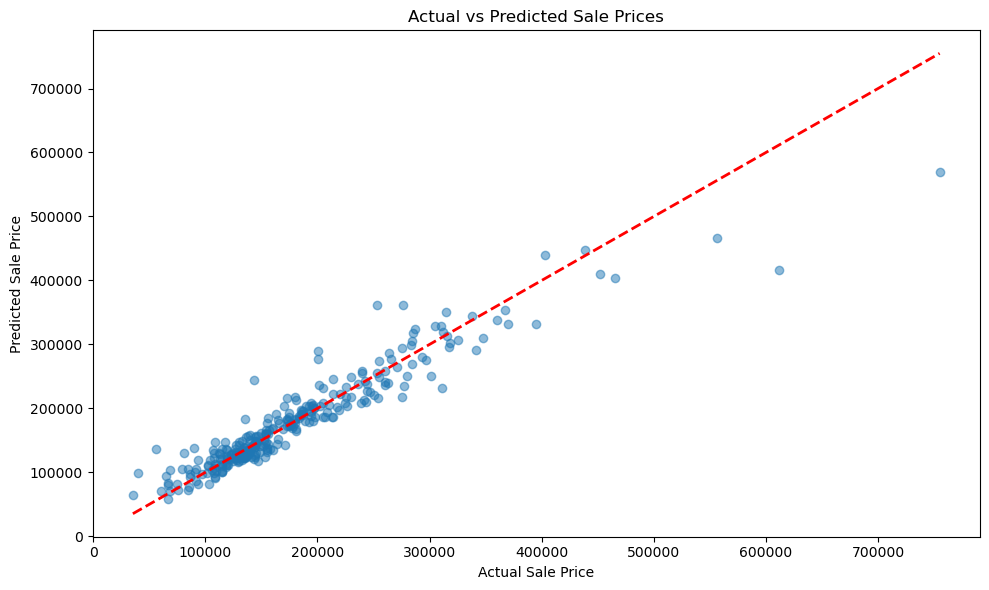

In [58]:
# Feature importance plot using the best model

# Scatter plot of predicted vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')
plt.title('Actual vs Predicted Sale Prices')
plt.tight_layout()
plt.show()